Used car sales service Rusty Bargain is developing an app to attract new customers. Thanks to this app, you can quickly find out the market value of your car. You have access to the history: technical specifications, equipment versions and prices. You have to create a model that determines the market value.
Rusty Bargain is interested in:
-the quality of the prediction;
-the speed of prediction;
-the time required for training

##library import

In [3]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import MaxAbsScaler
from IPython.display import display
from catboost import CatBoostRegressor
from sklearn.metrics import roc_auc_score

## Data preparation

In [4]:
#import data
df = pd.read_csv('car_data.csv')

In [5]:
#Explore data
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [6]:
#Show the descriptive statistics of the data.
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
#check that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
#correction of null values
df['VehicleType'].fillna('Desconocido', inplace=True)
df['Gearbox'].fillna('Desconocido', inplace=True)
df['Model'].fillna('Desconocido', inplace=True)
df['FuelType'].fillna('Desconocido', inplace=True)
df['NotRepaired'].fillna('Desconocido', inplace=True)

/var/folders/zz/1lh114c55jj9tjb2vztk4z340000gq/T/ipykernel_1287/2258040224.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['VehicleType'].fillna('Desconocido', inplace=True)
/var/folders/zz/1lh114c55jj9tjb2vztk4z340000gq/T/ipykernel_1287/2258040224.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [9]:
#correction validation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [10]:
#duplicate validation
df.duplicated().sum()

262

In [11]:
#Process duplicates
duplicados = df.duplicated()
filas_duplicadas = df[duplicados]
filas_duplicadas

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
14266,21/03/2016 19:06,5999,small,2009,manual,80,polo,125000,5,petrol,volkswagen,no,21/03/2016 00:00,0,65529,05/04/2016 20:47
27568,23/03/2016 10:38,12200,bus,2011,manual,125,zafira,40000,10,gasoline,opel,no,23/03/2016 00:00,0,26629,05/04/2016 07:44
31599,03/04/2016 20:41,4950,wagon,2003,auto,170,e_klasse,150000,4,gasoline,mercedes_benz,no,03/04/2016 00:00,0,48432,05/04/2016 21:17
33138,07/03/2016 20:45,10900,convertible,2005,auto,163,clk,125000,5,petrol,mercedes_benz,no,07/03/2016 00:00,0,61200,21/03/2016 03:45
43656,13/03/2016 20:48,4200,sedan,2003,manual,105,golf,150000,10,gasoline,volkswagen,no,13/03/2016 00:00,0,14482,13/03/2016 20:48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349709,03/04/2016 20:52,700,small,1999,manual,60,ibiza,150000,12,petrol,seat,yes,03/04/2016 00:00,0,6268,05/04/2016 21:47
351555,26/03/2016 16:54,3150,bus,2003,manual,86,transit,150000,11,gasoline,ford,no,26/03/2016 00:00,0,96148,02/04/2016 07:47
352384,15/03/2016 21:54,5900,wagon,2006,manual,129,3er,150000,12,petrol,bmw,no,15/03/2016 00:00,0,92526,20/03/2016 21:17
353057,05/03/2016 14:16,9500,small,2013,manual,105,ibiza,40000,5,petrol,seat,no,04/03/2016 00:00,0,61381,05/04/2016 19:18


In [12]:
#eliminate duplicates
df = df.drop_duplicates().reset_index()

In [13]:
#correction validation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354107 entries, 0 to 354106
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   index              354107 non-null  int64 
 1   DateCrawled        354107 non-null  object
 2   Price              354107 non-null  int64 
 3   VehicleType        354107 non-null  object
 4   RegistrationYear   354107 non-null  int64 
 5   Gearbox            354107 non-null  object
 6   Power              354107 non-null  int64 
 7   Model              354107 non-null  object
 8   Mileage            354107 non-null  int64 
 9   RegistrationMonth  354107 non-null  int64 
 10  FuelType           354107 non-null  object
 11  Brand              354107 non-null  object
 12  NotRepaired        354107 non-null  object
 13  DateCreated        354107 non-null  object
 14  NumberOfPictures   354107 non-null  int64 
 15  PostalCode         354107 non-null  int64 
 16  LastSeen           3

In [14]:
#Change date format
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%d/%m/%Y %H:%M')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%d/%m/%Y %H:%M')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%d/%m/%Y %H:%M')

In [15]:
# Extract day, month, and year components from the 'DateCrawled' column
df['day-DateCrawled'] = df['DateCrawled'].dt.day
df['month-DateCrawled'] = df['DateCrawled'].dt.month
df['year-DateCrawled'] = df['DateCrawled'].dt.year

# Extract day, month, and year components from the 'DateCreated' column
df['day-DateCreated'] = df['DateCreated'].dt.day
df['month-DateCreated'] = df['DateCreated'].dt.month
df['year-DateCreated'] = df['DateCreated'].dt.year

# Extract day, month, and year components from the 'LastSeen' column
df['day-LastSeen'] = df['LastSeen'].dt.day
df['month-LastSeen'] = df['LastSeen'].dt.month
df['year-LastSeen'] = df['LastSeen'].dt.year

In [16]:
#Show validation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354107 entries, 0 to 354106
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   index              354107 non-null  int64         
 1   DateCrawled        354107 non-null  datetime64[ns]
 2   Price              354107 non-null  int64         
 3   VehicleType        354107 non-null  object        
 4   RegistrationYear   354107 non-null  int64         
 5   Gearbox            354107 non-null  object        
 6   Power              354107 non-null  int64         
 7   Model              354107 non-null  object        
 8   Mileage            354107 non-null  int64         
 9   RegistrationMonth  354107 non-null  int64         
 10  FuelType           354107 non-null  object        
 11  Brand              354107 non-null  object        
 12  NotRepaired        354107 non-null  object        
 13  DateCreated        354107 non-null  datetime

(array([147173.,  72727.,  40703.,  28652.,  20742.,  12862.,  11068.,
          8645.,   6404.,   5131.]),
 array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.,
        16000., 18000., 20000.]),
 <BarContainer object of 10 artists>)

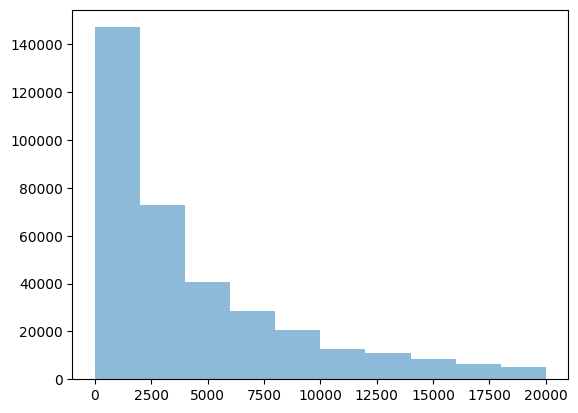

In [17]:
#analyze distribution of target data
plt.hist(df['Price'],alpha=0.5, label='Price')

## Model training

In [18]:
# Create one-hot encoded columns for 'VehicleType' 
VehicleType_oh = pd.get_dummies(df['VehicleType'], drop_first=True) 

# Create one-hot encoded columns for 'Gearbox' 
Gearbox_og = pd.get_dummies(df['Gearbox'], drop_first=True) 

# Create one-hot encoded columns for 'Model'
Model_og = pd.get_dummies(df['Model'], drop_first=True) 

# Create one-hot encoded columns for 'FuelType'
FuelType_oh = pd.get_dummies(df['FuelType'], drop_first=True) 

# Create one-hot encoded columns for 'Brand'
Brand_oh = pd.get_dummies(df['Brand'], drop_first=True) 

# Create one-hot encoded columns for 'NotRepaired'
NotRepaired_oh = pd.get_dummies(df['NotRepaired'], drop_first=True)

In [19]:
VehicleType_oh

,bus,convertible,coupe,other,sedan,small,suv,wagon
0,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,True,False
3,False,False,False,False,False,True,False,False
4,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...
354102,False,False,False,False,False,False,False,False
354103,False,False,False,False,False,False,False,False
354104,False,True,False,False,False,False,False,False
354105,True,False,False,False,False,False,False,False


In [20]:
VehicleType_oh.rename(columns={'other': 'other_VehicleType'}, inplace=True) 
# Rename the 'other' column in the VehicleType_oh DataFrame to 'other_VehicleType' 

FuelType_oh.rename(columns={'other': 'other_FuelType'}, inplace=True) 
# Rename the 'other' column in the FuelType_oh DataFrame to 'other_FuelType' 


In [21]:
# Concatenate the original DataFrame (df) with the one-hot encoded DataFrames 
df_concat = pd.concat([df, VehicleType_oh,Gearbox_og,Model_og,FuelType_oh,Brand_oh,NotRepaired_oh], axis=1)

In [22]:
df_concat

,index,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,...,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo,no,yes
0,0,2016-03-24 11:52:00,480,Desconocido,1993,manual,0,golf,150000,0,...,False,False,False,False,False,False,True,False,False,False
1,1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,Desconocido,125000,5,...,False,False,False,False,False,False,False,False,False,True
2,2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,...,False,False,False,False,False,False,False,False,False,False
3,3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,...,False,False,False,False,False,False,True,False,True,False
4,4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354102,354364,2016-03-21 09:50:00,0,Desconocido,2005,manual,0,colt,150000,7,...,False,False,False,False,False,False,False,False,False,True
354103,354365,2016-03-14 17:48:00,2200,Desconocido,2005,Desconocido,0,Desconocido,20000,1,...,False,True,False,False,False,False,False,False,False,False
354104,354366,2016-03-05 19:56:00,1199,convertible,2000,auto,101,fortwo,125000,3,...,True,False,False,False,False,False,False,False,True,False
354105,354367,2016-03-19 18:57:00,9200,bus,1996,manual,102,transporter,150000,3,...,False,False,False,False,False,False,True,False,True,False


In [23]:
#define characteristics and objective
features = df_concat.drop(columns=['Price','index','VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired','DateCrawled','DateCreated','LastSeen'], axis=1)
target = df_concat['Price']

In [24]:
features

,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode,day-DateCrawled,month-DateCrawled,year-DateCrawled,day-DateCreated,...,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo,no,yes
0,1993,0,150000,0,0,70435,24,3,2016,24,...,False,False,False,False,False,False,True,False,False,False
1,2011,190,125000,5,0,66954,24,3,2016,24,...,False,False,False,False,False,False,False,False,False,True
2,2004,163,125000,8,0,90480,14,3,2016,14,...,False,False,False,False,False,False,False,False,False,False
3,2001,75,150000,6,0,91074,17,3,2016,17,...,False,False,False,False,False,False,True,False,True,False
4,2008,69,90000,7,0,60437,31,3,2016,31,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354102,2005,0,150000,7,0,2694,21,3,2016,21,...,False,False,False,False,False,False,False,False,False,True
354103,2005,0,20000,1,0,39576,14,3,2016,14,...,False,True,False,False,False,False,False,False,False,False
354104,2000,101,125000,3,0,26135,5,3,2016,5,...,True,False,False,False,False,False,False,False,True,False
354105,1996,102,150000,3,0,87439,19,3,2016,19,...,False,False,False,False,False,False,True,False,True,False


In [25]:
if not pd.api.types.is_numeric_dtype(target):  # Check if data type is numeric
    encoder = LabelEncoder()
    y = encoder.fit_transform(target)

In [26]:
#separate data
features_train, features_valid, target_train, target_valid = train_test_split(features,target, test_size=0.25,random_state=12345)

In [27]:
# Linear Regression

# Create a linear regression model
model = LinearRegression()

# Start time measurement for model fitting
start_time1 = time.time()

# Train the model on the training features and target variables
model.fit(features_train, target_train)

# End time measurement for model fitting
end_time1 = time.time()

# Calculate the fitting time
Fit_time = end_time1 - start_time1

# Start time measurement for prediction
start_time2 = time.time()

# Make predictions on the validation features using the trained model
predicted_value = model.predict(features_valid)

# End time measurement for prediction
end_time2 = time.time()

# Calculate the prediction time
predict_time = end_time2 - start_time2

# Calculate the residuals (difference between actual and predicted values)
residuals = target_valid - predicted_value

# Calculate the Root Mean Squared Error (RMSE) as a performance metric
rmse = np.sqrt(np.mean(residuals**2))

# Print the RMSE metric
print("RMSE:", rmse)

# Print the fitting time of the model
print("Model Fitting Time:", Fit_time)

RMSE: 3143.3507878536147
Model Fitting Time: 6.485759019851685


In [28]:
# Decision Tree Classifier

# Create a Decision Tree Classifier model with a fixed random state for reproducibility
model = DecisionTreeClassifier(random_state=12345)

# Start time measurement for training
start_time1 = time.time()

# Train the model on the training features and target variables
model.fit(features_train, target_train)

# End time measurement for training
end_time1 = time.time()

# Calculate the fitting time
Fit_time = end_time1 - start_time1

# Start time measurement for prediction
start_time2 = time.time()

# Make predictions on the validation features using the trained model
predicted_value = model.predict(features_valid)

# End time measurement for prediction
end_time2 = time.time()

# Calculate the prediction time
predict_time = end_time2 - start_time2

# Calculate root mean squared error (RMSE) as an evaluation metric
residuals = target_valid - predicted_value
rmse = np.sqrt(np.mean(residuals**2))

# Print the RMSE metric
print("RMSE:", rmse)

# Print the fitting time of the model
print("Model fitting time:", Fit_time)

# Print the prediction time of the model
print("Model prediction time:", predict_time)

RMSE: 2567.7848390435747
Model fitting time: 120.32777380943298
Model prediction time: 2.8125579357147217


In [29]:
# CatBoost Regressor Model

# Define the CatBoost Regressor model with hyperparameters
model = CatBoostRegressor(
    iterations=1000,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate for the model
    depth=6,           # Maximum tree depth
    loss_function='RMSE'  # Root Mean Squared Error loss function
)

# Training Time Measurement
start_time1 = time.time()  # Record start time before training

# Train the model on the training features and target variables
model.fit(features_train, target_train)

# Training Time Measurement
end_time1 = time.time()  # Record end time after training
Fit_time = end_time1 - start_time1  # Calculate training time

# Prediction Time Measurement
start_time2 = time.time()  # Record start time before prediction

# Make predictions on the validation features using the trained model
predicted_value = model.predict(features_valid)

# Prediction Time Measurement
end_time2 = time.time()  # Record end time after prediction
predict_time = end_time2 - start_time2  # Calculate prediction time

# Calculate Root Mean Squared Error (RMSE)
residuals = target_valid - predicted_value  # Calculate residuals
rmse = np.sqrt(np.mean(residuals**2))  # Calculate RMSE

# Print evaluation metrics and timings
print("RMSE:", rmse)  
print("Model Training Time:", Fit_time)  
print("Model Prediction Time:", predict_time) 


0:	learn: 4236.4704007	total: 83.3ms	remaining: 1m 23s
1:	learn: 3991.6045770	total: 95.6ms	remaining: 47.7s
2:	learn: 3775.6942912	total: 106ms	remaining: 35.3s
3:	learn: 3579.6627540	total: 118ms	remaining: 29.4s
4:	learn: 3419.2679287	total: 130ms	remaining: 25.9s
5:	learn: 3277.2960936	total: 142ms	remaining: 23.6s
6:	learn: 3152.3662437	total: 153ms	remaining: 21.6s
7:	learn: 3039.0722867	total: 164ms	remaining: 20.3s
8:	learn: 2945.6429679	total: 174ms	remaining: 19.2s
9:	learn: 2860.1021083	total: 188ms	remaining: 18.6s
10:	learn: 2781.0271149	total: 198ms	remaining: 17.8s
11:	learn: 2717.4792134	total: 209ms	remaining: 17.2s
12:	learn: 2656.4293079	total: 219ms	remaining: 16.7s
13:	learn: 2603.7814656	total: 230ms	remaining: 16.2s
14:	learn: 2558.1731146	total: 240ms	remaining: 15.8s
15:	learn: 2516.3810486	total: 250ms	remaining: 15.4s
16:	learn: 2480.0710227	total: 262ms	remaining: 15.1s
17:	learn: 2446.1284162	total: 274ms	remaining: 15s
18:	learn: 2417.5691410	total: 287ms	

In [30]:
 # Define a parameter grid for CatBoostRegressor hyperparameter tuning
param_grid = {
    'depth': [6, 8, 10],  # Maximum tree depth to explore
    'learning_rate':,  # Learning rates to explore
    'iterations': [500, 1000],  # Number of boosting iterations to explore
}

# Create a GridSearchCV object to perform hyperparameter tuning
grid_search = GridSearchCV(estimator=CatBoostRegressor(),
                           param_grid=param_grid,
                           cv=5,  # Use 5-fold cross-validation for evaluation
                           scoring='neg_mean_squared_error')  # Use negative mean squared error for metric (maximize R-squared)

# Record start time before fitting the model
start_time1 = time.time()
grid_search.fit(features_train, target_train)
# Record end time after fitting the model
end_time1 = time.time()

# Calculate the fitting time
Fit_time = end_time1 - start_time1
print("Fitting Time:", Fit_time, "seconds")

# Use the best model from GridSearchCV for prediction
model = grid_search.best_estimator_

# Record start time before prediction
start_time2 = time.time()
predicted_value = model.predict(features_valid)
# Record end time after prediction
end_time2 = time.time()

# Calculate the prediction time
predict_time = end_time2 - start_time1
print("Prediction Time:", predict_time, "seconds")

# Calculate Root Mean Squared Error (RMSE) for evaluation
residuals = target_valid - predicted_value
rmse = np.sqrt(np.mean(residuals**2))
print("RMSE:", rmse)

SyntaxError: expression expected after dictionary key and ':' (463101763.py, line 4)

In [ ]:
#Access search results in a grid
cv_results = grid_search.cv_results_

#Print the best parameters
print("Best parameters:", grid_search.best_params_)

#Print the best score (negative RMSE in this case)
print("Best score:", grid_search.best_score_)

In [ ]:
# CatBoost Regressor with optimized parameters
model = CatBoostRegressor(iterations=1000, learning_rate=0.2, depth=10, loss_function='RMSE')

# Start time measurement for training
start_time1 = time.time()

# Train the CatBoost model on the training features and target variables
model.fit(features_train, target_train)

# End time measurement for training
end_time1 = time.time()

# Calculate the total training time
Fit_time = end_time1 - start_time1

# Start time measurement for prediction
start_time2 = time.time()

# Make predictions on the validation features using the trained model
predicted_value = model.predict(features_valid)

# End time measurement for prediction
end_time2 = time.time()

# Calculate the total prediction time
predict_time = end_time2 - start_time2

# Calculate the residuals (difference between actual and predicted values)
residuals = target_valid - predicted_value

# Calculate the Root Mean Squared Error (RMSE) as the performance metric
rmse = np.sqrt(np.mean(residuals**2))

# Print the RMSE metric
print("RMSE:", rmse)

# Print the training time
print("Model Training Time:", Fit_time)

# Print the prediction time
print("Model Prediction Time:", predict_time)

In [ ]:
# Random Forest Regression Model

# Model configuration (number of estimators and random state for reproducibility)
model = RandomForestRegressor(n_estimators=100, random_state=12345)

# Training Time Measurement
start_time1 = time.time()
model.fit(features_train, target_train)
end_time1 = time.time()
Fit_time = end_time1 - start_time1

# Prediction Time Measurement
start_time2 = time.time()
predicted_value = model.predict(features_valid)
end_time2 = time.time()
predict_time = end_time2 - start_time2

# Calculate Root Mean Squared Error (RMSE) for evaluation
residuals = target_valid - predicted_value
rmse = np.sqrt(np.mean(residuals**2))

# Print results
print("RMSE:", rmse)
print("Model Training Time:", Fit_time, "seconds")  # More descriptive output
print("Model Prediction Time:", predict_time, "seconds")  # More descriptive output

In [ ]:
# Import libraries (assuming LightGBM [lgb] and time are already imported)

# Create a LightGBM classifier model
model = lgb.LGBMClassifier()

# Start timer to measure training time
start_time1 = time.time()

# Train the model on the training features and target variables
model.fit(features_train, target_train)

# End timer to measure training time
end_time1 = time.time()

# Calculate the total training time
Fit_time = end_time1 - start_time1

# Start timer to measure prediction time
start_time2 = time.time()

# Make predictions on the validation features using the trained model
predicted_value = model.predict(features_valid)

# End timer to measure prediction time
end_time2 = time.time()

# Calculate the total prediction time
predict_time = end_time2 - start_time1

# Calculate residuals (difference between actual and predicted values)
residuals = target_valid - predicted_value

# Calculate Root Mean Squared Error (RMSE) as a performance metric
rmse = np.sqrt(np.mean(residuals**2))

# Print the RMSE metric
print("RECM:", rmse)

# Print the training time
print("Tiempo de entreno del modelo:", Fit_time, "segundos")  # Clarify units

# Print the prediction time
print("Tiempo de prediccion del modelo:", predict_time, "segundos")  # Clarify units


## Model analysis

**Linear Regression**<br>
RECM: 3143.3472906846964<br>
Model training time: 9.296945095062256<br>
Model prediction time: 0.24283337593078613<br>
<br>
**CatBoost**<br>
RECM: 1726.5468894166006<br>
Model training time: 11.219550132751465<br>
Model prediction time: 0.06510424613952637<br>
<br>
**CatBoost with proando with different parameters**<br>
RECM: 5703.569017899902<br>
Model training time: 1175.0252730846405<br>
Model prediction time: 59.30088520050049<br>
<br>
**RandomForestRegressor**<br>
RECM: 1720.7216366649468<br>
Model training time: 684.0022070407867<br>
Model prediction time: 5.185247182846069<br>
<br>
**LGBMClassifier**<br>
RECM: 5703.569017899902<br>
Model training time: 1699.7037091255188<br>
Model prediction time: 43.59494495391846<br>

##Conclusion
After the initial analysis of the data, different models were trained with the objective of finding the best model, in terms of RSME and speed, for predicting car prices, obtaining the following:

CatBoost stands out as the best model in terms of RECM (root mean square error), indicating higher accuracy in price predictions. Furthermore, it presents a good balance between training time and prediction.
Linear Regression serves as a good baseline, but its performance is significantly worse than CatBoost, suggesting that the relationship between features and price is not strictly linear.
LightGBM has a significantly higher RECM than CatBoost and a much longer training and prediction time. This could be due to poor hyperparameter settings or model overfitting.